# CMU Dataset Experimental Results

## Configure

In [ ]:
!mkdir dataset
!wget -O dataset/faces.tar.gz "https://archive.ics.uci.edu/ml/machine-learning-databases/faces-mld/faces.tar.gz"
!tar -xf "dataset/faces.tar.gz"

--2022-08-03 00:47:00--  https://archive.ics.uci.edu/ml/machine-learning-databases/faces-mld/faces.tar.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10008005 (9.5M) [application/x-httpd-php]
Saving to: ‘dataset/faces.tar.gz’

dataset/faces.tar.g 100%[===================>]   9.54M  7.36MB/s    in 1.3s    

2022-08-03 00:47:02 (7.36 MB/s) - ‘dataset/faces.tar.gz’ saved [10008005/10008005]



In [ ]:
!pip install mediapipe

import os
import re

import mediapipe as mp
import cv2
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import sklearn.metrics as metrics

import seaborn as sns

import statsmodels.stats.weightstats as wstats
import statsmodels.formula.api as smf

import scipy.stats as stats

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 32.9 MB 148 kB/s 


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Load Data

In [ ]:
# [dir for subdir in os.listdir('dataset/faces') for dir in os.listdir(os.path.join('dataset/faces', subdir))]
files = [os.path.join('faces', subdir, filename)
  for subdir in os.listdir('faces') if subdir != '.anonr'
  for filename in os.listdir(os.path.join('faces', subdir))
]
file_map = {
    'faces/phoebe/phoebe_left_angry_open.bad': 'faces/phoebe/phoebe_right_angry_open.pgm'
}
files = [file_map[f] if f in file_map.keys() else f for f in files] 
pattern = re.compile(r'.*(left|right|straight|up).*')
alignments = [pattern.findall(f)[0] for f in files]
df = pd.DataFrame(
    data = {
        'image': files,
        'alignment': alignments,
    }
)

## Process Data

In [ ]:
landmark_indices = [
    # left_iris
    469, 470,
    471, 472,
    
    # right iris
    474, 475,
    476, 477,

    # nose
    1,

    # left eye, right to left
    158, 159, 160,
    153, 145, 144,
    # left eye left - right
    33, 133, 

    # right eye, right to left
    387, 386, 385,
    373, 374, 380,
    # right eye left - right
    362, 263
]

In [ ]:
coor_columns = [item for sublist in [(f'{idx}_x', f'{idx}_y') for idx in landmark_indices] for item in sublist]
coor_df = pd.DataFrame(
    data = {
        col: np.zeros(df.shape[0])
        for col in coor_columns
    }, 
)

In [ ]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh = mp.solutions.face_mesh

# For static images:
IMAGE_FILES = df.image.to_list()
N_IMAGES = df.shape[0]
na_idx = []
with mp_face_mesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5) as face_mesh:
  for idx, file in enumerate(IMAGE_FILES):
    print(f'{idx / N_IMAGES * 100}% analyzed', end = '\r')
    image = cv2.imread(file)
    # Convert the BGR image to RGB before processing.
    try:
      results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    except:
      na_idx.append(idx)
      print(f'Exception occured while processing {file} at index {idx}')
      continue
    # results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_GRAY2RGB))

    # Print and draw face mesh landmarks on the image.
    if not results.multi_face_landmarks:
      na_idx.append(idx)
      continue
    annotated_image = image.copy()
    for face_landmarks in results.multi_face_landmarks:
      ls = face_landmarks
      xs = [landmark.x for landmark in face_landmarks.landmark]
      ys = [landmark.y for landmark in face_landmarks.landmark]
      zs = [landmark.z for landmark in face_landmarks.landmark]
      xs = np.array(xs)
      ys = np.array(ys)
      zs = np.array(zs)
      std_xs = (xs - xs.mean()) / xs.std()
      std_ys = (ys - ys.mean()) / ys.std()
      std_zs = (zs - zs.mean()) / zs.std()

      for lm_idx in landmark_indices:
        coor_df.loc[idx, f'{lm_idx}_x'] = std_xs[lm_idx]
        coor_df.loc[idx, f'{lm_idx}_y'] = std_ys[lm_idx]

      # left_eye_top = np.array([std_xs[159], std_ys[159]])
      # left_eye_btn = np.array([std_xs[145], std_ys[145]])

      # dist = np.linalg.norm(left_eye_top - left_eye_btn)

      # threshold = std_xs[1] * 0.0308 + std_ys[1] * 0.0803 + 0.1476
      # blink_df.at[idx, 'predicted'] = int(dist <= threshold - 0.05)
df[coor_df.columns] = coor_df
processed_df = df.drop(df.index[na_idx])
align_map = {
    'left': 'right',
    'right': 'left'
}
processed_df['alignment'] = processed_df['alignment'].replace(align_map)
processed_df.to_csv('cmu_coors.csv')

## Exploratory Analysis

In [ ]:
def dist_plot(func):
  def wrapper(xs, *arg, **kwargs):
    mean = xs.mean()
    std = xs.std()
    xs = [x for x in xs if x > (mean - 2 * std) and x < (mean + 2 * std)]
    return func(xs, *arg, **kwargs)
  return wrapper

def raw_dist_plot(xs, *args, **kwargs):
  percentile = kwargs['percentile']
  ax = kwargs.get('ax', None)
  sns.histplot(xs, kde=True, ax = ax, stat='density')
  if ax:
    ax.axvline(np.percentile(xs, percentile), 0, 40, color = 'r')
  else:
    plt.axvline(np.percentile(xs, percentile), 0, 40, color = 'r')
  print(np.percentile(xs, percentile))

dist_plot = dist_plot(raw_dist_plot)

-0.5899034130355034


(-44.05035443743303, 0.0)

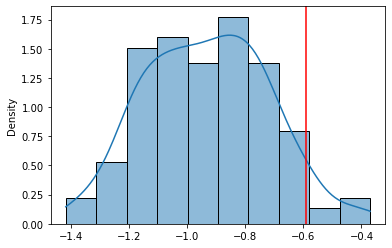

In [ ]:
dist_plot(processed_df[processed_df.alignment == 'left']['1_x'], percentile = 95)
wstats.ztest(processed_df[processed_df.alignment == 'left']['1_x'], alternative = 'smaller')

0.6845725671278344


(81.09961404085838, 0.0)

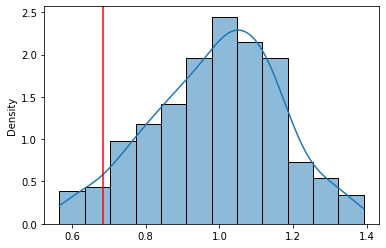

In [ ]:
dist_plot(processed_df[processed_df.alignment == 'right']['1_x'], percentile = 5)
wstats.ztest(processed_df[processed_df.alignment == 'right']['1_x'], alternative = 'larger')

0.02417669412385383
-0.5899034130355034
0.6845725671278344


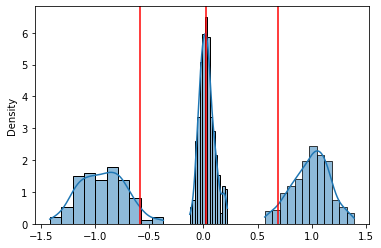

In [ ]:
dist_plot(processed_df[processed_df.alignment == 'straight']['1_x'], percentile = 50)
dist_plot(processed_df[processed_df.alignment == 'left']['1_x'], percentile = 95)
dist_plot(processed_df[processed_df.alignment == 'right']['1_x'], percentile = 5)

0.05839333386787521


(-20.0983302063562, 3.815928807558706e-90)

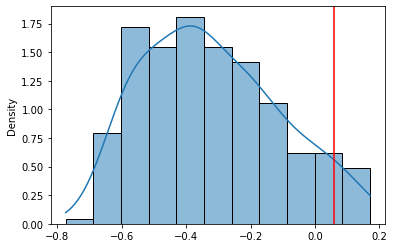

In [ ]:
dist_plot(processed_df[processed_df.alignment == 'up']['1_y'], percentile = 95)
wstats.ztest(processed_df[processed_df.alignment == 'up']['1_y'], alternative = 'smaller')

0.05839333386787521
0.22306660005652384


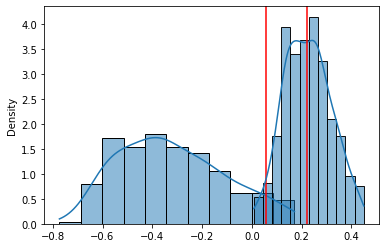

In [ ]:
dist_plot(processed_df[processed_df.alignment == 'up']['1_y'], percentile = 95)
dist_plot(processed_df[processed_df.alignment == 'straight']['1_y'], percentile = 50)

0.02417669412385383


(8.816566308073101, 1.1802331706643778e-18)

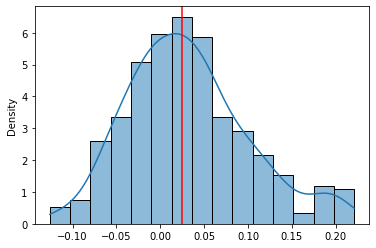

In [ ]:
dist_plot(processed_df[processed_df.alignment == 'straight']['1_x'], percentile = 50)
wstats.ztest(processed_df[processed_df.alignment == 'straight']['1_x'])

0.22306660005652384


(42.40794540240443, 0.0)

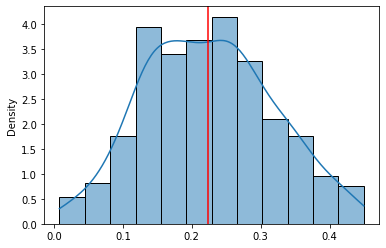

In [ ]:
dist_plot(processed_df[processed_df.alignment == 'straight']['1_y'], percentile = 50)
wstats.ztest(processed_df[processed_df.alignment == 'straight']['1_y'])

In [ ]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh = mp.solutions.face_mesh

true_xs_list = []
true_ys_list = []
true_std_xs = []
true_std_ys = []
std_xs = []
std_ys = []
annotated_images = []
# For static images:
IMAGE_FILES = [f for f in df.image if 'straight_neutral_open.pgm' in f]
blinks = []
with mp_face_mesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5) as face_mesh:
  for idx, file in enumerate(IMAGE_FILES):
    image = cv2.imread(file)
    # Convert the BGR image to RGB before processing.
    results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    # results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_GRAY2RGB))
    # Print and draw face mesh landmarks on the image.
    if not results.multi_face_landmarks:
      continue
    annotated_image = image.copy()
    for face_landmarks in results.multi_face_landmarks:
      ls = face_landmarks
      xs = [landmark.x for landmark in face_landmarks.landmark]
      ys = [landmark.y for landmark in face_landmarks.landmark]
      zs = [landmark.z for landmark in face_landmarks.landmark]
      xs = np.array(xs)
      ys = np.array(ys)
      zs = np.array(zs)
      
      true_xs = xs * annotated_image.shape[0]
      true_ys = ys * annotated_image.shape[1]
      true_std_xs.append((true_xs - true_xs.mean()) / true_xs.std())
      true_std_ys.append((true_ys - true_ys.mean()) / true_ys.std())
      true_xs_list.append(true_xs)
      true_ys_list.append(true_ys)

      std_xs.append((xs - xs.mean()) / xs.std())
      std_ys.append((ys - ys.mean()) / ys.std())
      # std_zs = (zs - zs.mean()) / zs.std()
      # print(std_xs[1], std_xs[1])

      # left_eye_top = np.array([std_xs[159], std_ys[159]])
      # left_eye_btn = np.array([std_xs[145], std_ys[145]])

      # dist = np.linalg.norm(left_eye_top - left_eye_btn)

      # threshold = std_xs[1] * 0.0308 + std_ys[1] * 0.0803 + 0.1476
      # s014_blink_df.at[idx, 'predicted'] = int(dist <= threshold)
      mp_drawing.draw_landmarks(
          image=annotated_image,
          landmark_list=face_landmarks,
          connections=mp_face_mesh.FACEMESH_TESSELATION,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp_drawing_styles
          .get_default_face_mesh_tesselation_style())
      mp_drawing.draw_landmarks(
          image=annotated_image,
          landmark_list=face_landmarks,
          connections=mp_face_mesh.FACEMESH_CONTOURS,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp_drawing_styles
          .get_default_face_mesh_contours_style())
      mp_drawing.draw_landmarks(
          image=annotated_image,
          landmark_list=face_landmarks,
          connections=mp_face_mesh.FACEMESH_IRISES,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp_drawing_styles
          .get_default_face_mesh_iris_connections_style())
      annotated_images.append(annotated_image)


In [ ]:
stats.f_oneway(*std_xs)

F_onewayResult(statistic=5.440888795821931e-29, pvalue=1.0)

In [ ]:
cmu_xs_f_test_df = pd.DataFrame(
    data = {
        f'person_{idx}_x': xs
        for idx, xs in enumerate(std_xs)
    }
)
cmu_xs_f_test_df.describe()

,person_0_x,person_1_x,person_2_x,person_3_x,person_4_x,person_5_x,person_6_x,person_7_x,person_8_x,person_9_x,person_10_x,person_11_x,person_12_x,person_13_x,person_14_x,person_15_x,person_16_x,person_17_x,person_18_x,person_19_x
count,4.780000e+02,4.780000e+02,4.780000e+02,4.780000e+02,4.780000e+02,4.780000e+02,4.780000e+02,4.780000e+02,4.780000e+02,4.780000e+02,4.780000e+02,4.780000e+02,4.780000e+02,4.780000e+02,4.780000e+02,4.780000e+02,4.780000e+02,4.780000e+02,4.780000e+02,4.780000e+02
mean,2.972982e-16,1.189193e-16,1.189193e-16,-1.783789e-16,3.567579e-16,-2.972982e-16,-2.378386e-16,-8.324350e-16,3.567579e-16,1.189193e-16,5.945964e-16,-5.945964e-17,3.567579e-16,-1.783789e-16,-1.783789e-16,1.189193e-16,-2.972982e-16,-4.162175e-16,-2.378386e-16,1.783789e-16
std,1.001048e+00,1.001048e+00,1.001048e+00,1.001048e+00,1.001048e+00,1.001048e+00,1.001048e+00,1.001048e+00,1.001048e+00,1.001048e+00,1.001048e+00,1.001048e+00,1.001048e+00,1.001048e+00,1.001048e+00,1.001048e+00,1.001048e+00,1.001048e+00,1.001048e+00,1.001048e+00
min,-2.271093e+00,-2.060087e+00,-2.200063e+00,-2.238497e+00,-2.155602e+00,-2.153145e+00,-2.276684e+00,-2.240023e+00,-2.163131e+00,-2.069108e+00,-2.194511e+00,-2.272049e+00,-2.211455e+00,-2.204509e+00,-2.196286e+00,-2.361883e+00,-2.069991e+00,-2.321325e+00,-2.087410e+00,-2.327835e+00
25%,-6.153990e-01,-6.987343e-01,-5.967723e-01,-6.651246e-01,-6.379618e-01,-6.352744e-01,-6.722558e-01,-6.390393e-01,-6.663055e-01,-6.268807e-01,-6.406222e-01,-6.287543e-01,-6.436496e-01,-6.366485e-01,-6.594605e-01,-6.165043e-01,-6.802073e-01,-6.635870e-01,-6.816773e-01,-5.985249e-01
50%,5.055174e-02,-4.765404e-02,5.993336e-03,3.471999e-02,-9.234920e-04,-2.504295e-02,3.420817e-02,6.815042e-02,2.301531e-02,-8.672310e-03,2.894234e-02,4.766262e-02,4.450696e-03,1.253506e-02,4.476833e-02,7.167950e-02,-1.824846e-02,3.016612e-02,-1.334717e-02,5.879389e-02
75%,6.893272e-01,6.665377e-01,6.113038e-01,7.012940e-01,6.590476e-01,6.298033e-01,6.411243e-01,6.984059e-01,7.065797e-01,6.827289e-01,7.044566e-01,6.377931e-01,6.583980e-01,6.924125e-01,7.087728e-01,6.790628e-01,7.176032e-01,6.703244e-01,6.753649e-01,6.310565e-01
max,2.071858e+00,2.145247e+00,2.192630e+00,2.083578e+00,2.129687e+00,2.208946e+00,2.041345e+00,1.974855e+00,2.078360e+00,2.275647e+00,2.063234e+00,1.994883e+00,2.092077e+00,2.071519e+00,2.061472e+00,2.027775e+00,2.069204e+00,2.043992e+00,2.136850e+00,2.059516e+00


### Standardized Landmark Distributions

0.050551742610951626
-0.04765404220321373
0.005993335527026125
0.03471998581394741
-0.0009234920409708017
-0.025042948471854225
0.034208174112512646
0.06815042033695154
0.023015313519294145
-0.008672310428521863
0.028942336012931565
0.04766262053199016
0.0044506958959236575
0.012535063733555896
0.04476833161972388
0.07167949722892544
-0.01824846240313791
0.03016612165991494
-0.013347167878915052
0.05879389216145367


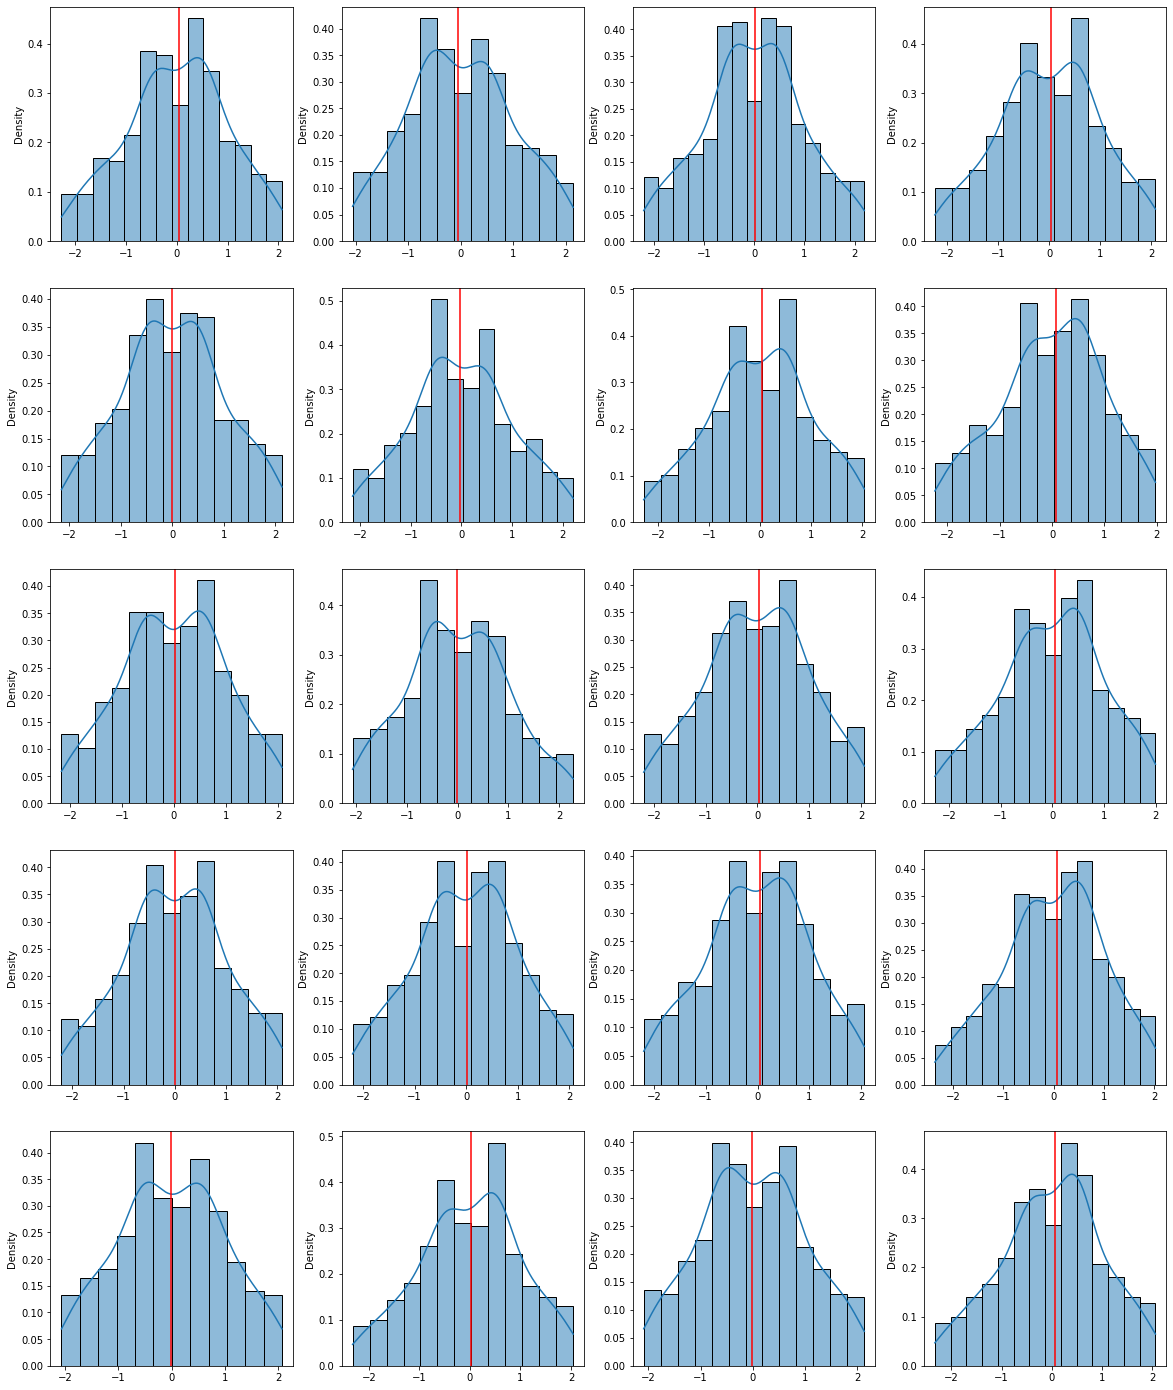

In [ ]:
fig, axs = plt.subplots(nrows = 5, ncols = 4, figsize = (20, 25))
axs = axs.flatten()
for idx, xs in enumerate(std_xs):
  raw_dist_plot(xs, ax = axs[idx], percentile = 50)

In [ ]:
stats.f_oneway(*std_ys)

F_onewayResult(statistic=4.7265294426704473e-29, pvalue=1.0)

0.06801697388792885
0.056925177100451974
0.04797826703060914
0.059145077661490214
0.023992756412570274
0.06817599291376833
0.044418390276495585
-0.006034277708061418
0.024909751179562553
0.06961398619079762
0.002692858982699188
0.06835429603738727
0.026859297350203315
0.045473737543389556
0.017879704949765637
0.03486736201893767
-0.03167563911481272
0.0327361081424295
0.062073871814053896
0.05046609947260039


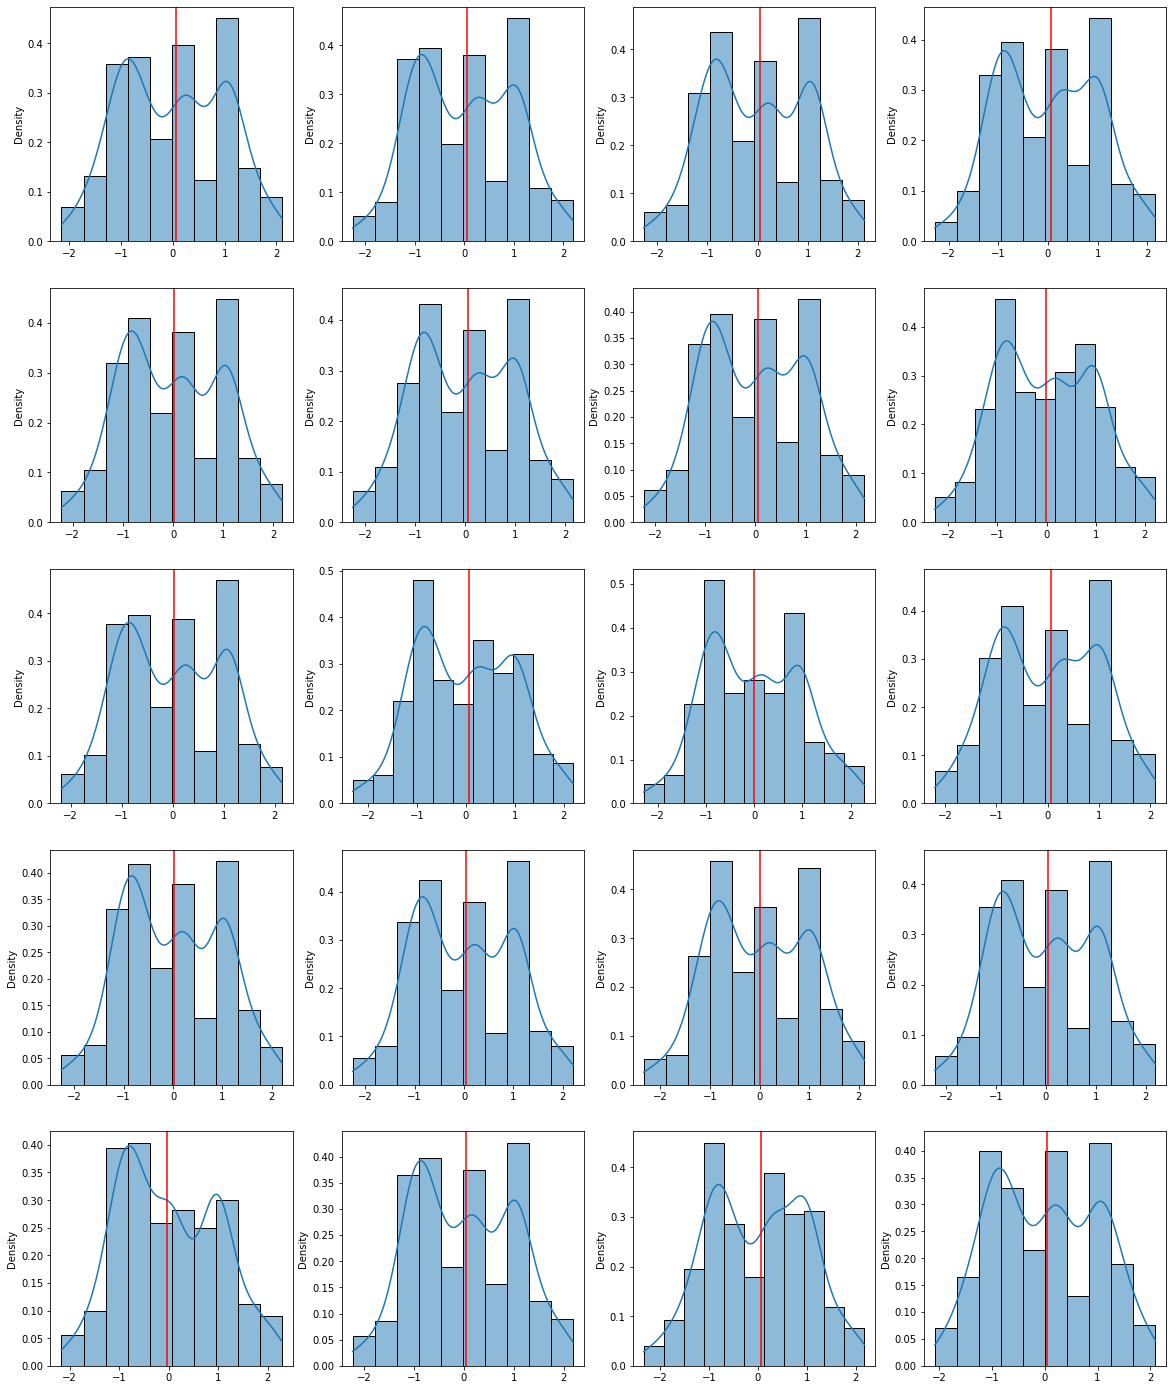

In [ ]:
fig, axs = plt.subplots(nrows = 5, ncols = 4, figsize = (20, 25))
axs = axs.flatten()
for idx, ys in enumerate(std_ys):
  raw_dist_plot(ys, ax = axs[idx], percentile = 50)

In [ ]:
def vertical_alignment(y):
  if y <= 0.058:
  # if y <= -0.05:
    return 'up'
  elif y >= 0.6:
    return 'down'
  else:
    return 'straight'

def horizontal_alignment(x):
  if x <= -0.3:
    return 'left'
  elif x >= 0.3:
    return 'right'
  else:
    return 'straight'

def combined_alignment(idx):
  horizontal_align = horizontal_alignment(processed_df.iloc[idx]['1_x'])
  vertical_align = vertical_alignment(processed_df.iloc[idx]['1_y'])
  alignment = processed_df.iloc[idx]['alignment']
  if alignment == 'left':
    return horizontal_align
  elif alignment == 'right':
    return horizontal_align
  elif alignment == 'up':
    return vertical_align
  else:
    misaligns = [align for align in [horizontal_align, vertical_align] if align != 'straight']
    return misaligns[0] if misaligns else 'straight'
predicteds = [combined_alignment(idx) for idx in range(processed_df.shape[0])]

### Confusion Matrix and Metrics

[Text(0, 0.5, 'left'),
 Text(0, 1.5, 'right'),
 Text(0, 2.5, 'up'),
 Text(0, 3.5, 'straight')]

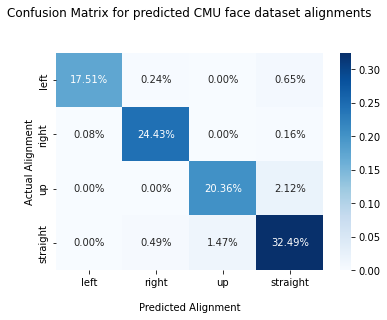

In [ ]:
alignment_labels = ['left', 'right', 'up', 'straight']
cf_matrix = metrics.confusion_matrix(processed_df.alignment, predicteds, labels = alignment_labels)
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Confusion Matrix for predicted CMU face dataset alignments\n\n');
ax.set_xlabel('\nPredicted Alignment')
ax.set_ylabel('Actual Alignment');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(alignment_labels)
ax.yaxis.set_ticklabels(alignment_labels)

In [ ]:
predicted_labels = [alignment_labels.index(predicted) for predicted in predicteds]
truth_labels = [alignment_labels.index(alignment) for alignment in processed_df.alignment]

In [ ]:
metrics.f1_score(processed_df.alignment, predicteds, average='micro')

0.9478827361563518

In [ ]:
metrics.accuracy_score(processed_df.alignment, predicteds)

0.9478827361563518